# Image Compression & Classificaiton Prediction

### Team 1 Final Project Report
#### Arthur: Lydia Niu, Ryan Kim, Stuart Arief, Colin Pham, Jonathan Chun

## Introduction

#### After compressing images using k-means clustering, we will turn compression into a prediction problem. We are using k-means clustering to compress images, measure how much quality is lost, and then use a supervised model (KNN) to predict which images belong to a certain category.

## Initial Questions: 
#### 1. Since images vary in how compressible they are, can we measure and predict compression quality?
#### 2. Are there certain patterns or image attributes, such as brightness, color density, or overall complexity, that make some images easier to compress than others?


## Dataset

#### The dataset consists of 119 images curated across five thematic albums, architecture, landscapes, portraits, still life, and urban street scenes. Each of the album highlight different visual properties. The diversity of scenes, which ranging from highly structured architectures to complex natural textures, provides a broad test bed for evaluating how k-means clustering performs under varying color distributions, edge structures, and lighting conditions.
#### The link of the album: https://docs.google.com/presentation/d/11lTfTXgLVy_cAzzh6rujusyNi2xRTISkRa52MyvfTe8/edit?slide=id.g3a5e2ce8d78_0_2812#slide=id.g3a5e2ce8d78_0_2812



## Presentation Slides link
#### We summarized this project into a google slides presentaion.

#### The link of the presentation slides: https://docs.google.com/presentation/d/11lTfTXgLVy_cAzzh6rujusyNi2xRTISkRa52MyvfTe8/edit?slide=id.g3a5e2ce8d78_0_2812#slide=id.g3a5e2ce8d78_0_2812

## Technique 
### [we're using k-means clustering. what is k-means clustering? how does it work? why we use it? what are the k values we are using? etc]

## Compression - K-means clustering

Compressed image saved as compressed_image.jpg with 32 colors.


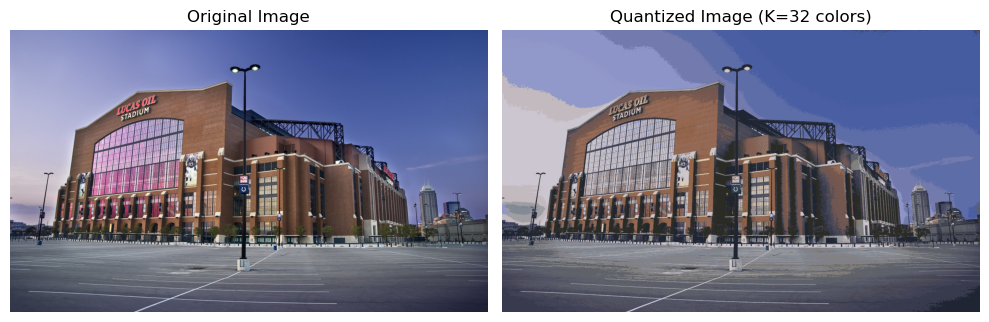

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt



# ello - READ THIS 

# make sure cv2 is downloaded. Change file input/output names as well as K values below  
# sometimes it might take a fat minute to load
#------------------------------------------------------------------------------------------------
image_path = "originals/architecture/arc1.jpg"  # CHANGE THIS TO THE CORRECT FILE NAME DO NOT FORGET 
output_path = "compressed_image.jpg"  
K = 32  # MODIFY K  
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Could not load image at {image_path}")
#------------------------------------------------------------------------------------------------

# image dimensions
height, width = image.shape[:2]

# turn into 2d array of RBG values
flat_pixels = image.reshape(-1, 3).astype(np.float32)  
num_pixels = flat_pixels.shape[0]  

# choose k 
random_indices = np.random.choice(num_pixels, size=K, replace=False)
representative_colors = flat_pixels[random_indices]  
diff = flat_pixels[:, None, :] - representative_colors[None, :, :]
distances_sq = np.sum(diff**2, axis=2)  

# Distance to nearest color calculations
nearest_color_idx = np.argmin(distances_sq, axis=1)  
quantized_flat_pixels = representative_colors[nearest_color_idx]  
quantized_flat_pixels = np.rint(quantized_flat_pixels).astype(np.uint8)
quantized_image = quantized_flat_pixels.reshape(height, width, 3)

cv2.imwrite(output_path, quantized_image)
print(f"Compressed image saved as {output_path} with {K} colors.")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
quantized_image_rgb = cv2.cvtColor(quantized_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis('off')  
plt.subplot(1, 2, 2)
plt.imshow(quantized_image_rgb)
plt.title(f"Quantized Image (K={K} colors)")
plt.axis('off')
plt.tight_layout()
plt.show()


## EDA - Matrix of SSIM and MSE for Image Comparison

### [ how to measure the error? function to calculate the metrics, mse and ssim]

### [what is mse and ssim, what do they represent?]

In [ ]:
import cv2
import numpy as np
import os
import glob
import pandas as pd
from skimage.metrics import structural_similarity as ssim 

# --- Metric Calculation Function ---
def calculate_metrics(original_img, compressed_img):
    """
    Calculates MSE and SSIM between the original and compressed images.
    """
    
    # Ensure images have the same shape
    if original_img.shape != compressed_img.shape:
        raise ValueError("Original and compressed images must have the same dimensions.")
        
    # 1. Mean Squared Error (MSE)
    error = np.sum((original_img.astype("float") - compressed_img.astype("float")) ** 2)
    N = float(original_img.shape[0] * original_img.shape[1] * original_img.shape[2])
    mse = error / N
    
    # 2. Structural Similarity Index Measure (SSIM)
    original_gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    compressed_gray = cv2.cvtColor(compressed_img, cv2.COLOR_BGR2GRAY)

    ssim_score = ssim(original_gray, compressed_gray, data_range=255, channel_axis=None)
    
    return mse, ssim_score

### function to generate error matrix by category in different k values.

In [ ]:
# --- Detailed Matrix Generation Function ---
def generate_category_matrix(category_name, prefix, k_values, originals_dir="originals", compressed_dir="compressed"):
    """
    Generates the error matrix for a single image category, sorted by image ID and K-Value.
    
    Returns:
        pandas.DataFrame: The resulting error matrix for the category.
    """
    
    original_path = os.path.join(originals_dir, category_name)
    compressed_mod_path = os.path.join(compressed_dir, f"{category_name}_mod")
    
    original_files = glob.glob(os.path.join(original_path, f"{prefix}*.jpg"))
    
    if not original_files:
        print(f"Warning: No original files found for category '{category_name}'.")
        return pd.DataFrame()
        
    results = []
    
    print(f"\n--- Processing Category: {category_name.upper()} ---")

    for og_file_path in original_files:
        base_filename = os.path.basename(og_file_path)
        image_id = os.path.splitext(base_filename)[0]
        
        og_image = cv2.imread(og_file_path)
        if og_image is None:
            print(f"Skipping {base_filename}: could not load original image.")
            continue
            
        for K in k_values:
            compressed_filename = f"{image_id}_K{K}.jpg" 
            compressed_file_path = os.path.join(compressed_mod_path, compressed_filename)
            
            comp_image = cv2.imread(compressed_file_path)
            
            if comp_image is None:
                print(f"  - Missing compressed file for {image_id} at K={K}. Skipping.")
                continue

            mse, ssim_score = calculate_metrics(og_image, comp_image)
            
            # Store the numeric part of the ID (e.g., 1, 2, 3) for sorting
            # This handles file names like arc1, port5, etc.
            image_num_id = int(''.join(filter(str.isdigit, image_id)))
            
            results.append({
                'Image_ID': image_id,
                'Image_Num_ID': image_num_id,
                'K_Value': K,
                'MSE': round(mse, 4),
                'SSIM': round(ssim_score, 4)
            })

    df = pd.DataFrame(results)
    
    # Requirement 1 & 2: Sort by numeric Image ID (ascending) then by K_Value (ascending)
    df = df.sort_values(by=['Image_Num_ID', 'K_Value']).drop(columns=['Image_Num_ID']).reset_index(drop=True)
    
    return df

In [ ]:

# --- Execution Block (Modified for K-Specific Summary) ---

K_VALUES_TO_CHECK = [4, 8, 16] 

CATEGORIES = [
    {'name': 'architecture', 'prefix': 'arc'},
    {'name': 'landscapes', 'prefix': 'land'},
    {'name': 'portraits', 'prefix': 'port'},
    {'name': 'still_life', 'prefix': 'life'},
    {'name': 'urban', 'prefix': 'urb'},
    
]

# Initialize a list to hold all the K-specific summary rows
k_summary_rows = []
all_matrices = {}

for cat in CATEGORIES:
    df_matrix = generate_category_matrix(
        category_name=cat['name'],
        prefix=cat['prefix'],
        k_values=K_VALUES_TO_CHECK
    )
    
    if not df_matrix.empty:
        # Group the detailed matrix by K_Value and calculate the mean for MSE and SSIM
        k_avg_df = df_matrix.groupby('K_Value')[['MSE', 'SSIM']].mean().reset_index()
        
        # Add a 'Category' column
        k_avg_df['Category'] = cat['name'].title()
        
        # Format the averages and rename columns
        k_avg_df['Average MSE'] = k_avg_df['MSE'].round(4)
        k_avg_df['Average SSIM'] = k_avg_df['SSIM'].round(4)
        
        # Select and reorder columns as required: Category, K_Value, Avg MSE, Avg SSIM
        final_cols = ['Category', 'K_Value', 'Average MSE', 'Average SSIM']
        k_summary_rows.append(k_avg_df[final_cols])
    
    all_matrices[cat['name']] = df_matrix

# --- Display the results and summaries ---

print("\n\n#####################################################")
print("#### DETAILED ERROR MATRIX SUMMARY BY CATEGORY ####")
print("#####################################################")

# Display the detailed matrices
for category, matrix in all_matrices.items():
    print(f"\n\n--- DETAILED MATRIX: {category.upper()} (K={K_VALUES_TO_CHECK}) ---")
    if not matrix.empty:
        print(matrix.to_markdown(index=False))
    else:
        print("No data available for this category.")

# Display the overall summary (New K-specific format)
print("\n" + "="*70)
print("### CATEGORY OVERALL PERFORMANCE SUMMARY BY K-VALUE (15 Rows) ###")
print("="*70)

# Concatenate all the K-specific summary DataFrames
if k_summary_rows:
    summary_df = pd.concat(k_summary_rows, ignore_index=True)
    
    # Final sort: Group by Category (alphabetical) then K_Value (4, 8, 16)
    # The K_Value sort is crucial for Requirement 2/3
    summary_df = summary_df.sort_values(by=['Category', 'K_Value']).reset_index(drop=True)
    
    print(summary_df.to_markdown(index=False))
else:
    print("No summary data was generated.")
print("="*70)


--- Processing Category: ARCHITECTURE ---

--- Processing Category: LANDSCAPES ---

--- Processing Category: PORTRAITS ---

--- Processing Category: STILL_LIFE ---

--- Processing Category: URBAN ---


#####################################################
#### DETAILED ERROR MATRIX SUMMARY BY CATEGORY ####
#####################################################


--- DETAILED MATRIX: ARCHITECTURE (K=[4, 8, 16]) ---
| Image_ID   |   K_Value |       MSE |   SSIM |
|:-----------|----------:|----------:|-------:|
| arc1       |         4 |  446.841  | 0.8022 |
| arc1       |         8 |  191.564  | 0.8498 |
| arc1       |        16 |  195.554  | 0.8889 |
| arc2       |         4 |  555.808  | 0.8346 |
| arc2       |         8 |  143.579  | 0.8702 |
| arc2       |        16 |  346.135  | 0.8348 |
| arc3       |         4 | 1018.65   | 0.7189 |
| arc3       |         8 |  427.428  | 0.7627 |
| arc3       |        16 |  431.874  | 0.7416 |
| arc4       |         4 |  413.322  | 0.8439 |
| arc4

# Analysis

As evident by the compressed images, the colors are approximated using K-Means method and then stored into clusters based on their similarity. From this, an approximation of the colors is formed and applied to all the pixels that fall within that particular cluster. This means that the larger the defined K value is, the closer the produced image will be to the original image. 

In terms of the error, portraits have the lowest average MSE at 276.53 and a low overall SSIM of 0.7857. This indicates an overall low compression quality for this category of image. While the numerical change between a pixel's color value is low (MSE), the low SSIM means that the structural information of the entire image is poor. A possible explanation for these values would be the smoothness of the subjects' skin, subtle lighting with tonal gradients, and blurred backgrounds. All of these factors contribute to making a complex image that is difficult for the colors to be approximated and put into clusters.

On the other hand, Still Life images have the highest average SSIM at 0.8464, and an average MSE of 305.19. This indicates that it has the best preservation of quality after the compression algorithm is run. An explanation for this high performance is from the nature of Still Life images as a whole, where objects are well defined and have relatively smooth surfaces, making color clustering an effective method to use for compression.

# Conclusion

Going back to our hypothesis and cross referencing it to our matrix of results for each category, we can conclude that compression performance is indeed worse for images with higher edge density and color diversity when the k value is low. Architecture and Urban images exhibit high average MSE at k=4 (452 and 453 respectively), and low SSIM (0.796 and 0.729 respectively). This combination indicates a low compression performance due to there being an insufficient amount of clusters to accomodate the high variety of colors, ultimately resulting in a major loss in quality after compression is applied. Thus, the hypothesis is reinforced.

# Team Contribution

Ryan Kim
*   Image dataset collection and category contribution.
*   File compression testing and exporting for various k values across all categories.
*   Video report editing and documentation.

Stuart Arief:
*   Analysis and Conclusion 

Lydia Niu
* Create reproduceble functions to calculate MSE and SSIM and gemerate error matrix 
* Final report compilation

Jonathan Chun - 

Colin Pham - 